# Begin visualisations

In [1]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress
import ipywidgets as widgets
from pprint import pprint
import py4cytoscape as p4c
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [2]:
working = Path('..')
working

PosixPath('..')

In [3]:
!pwd

/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/notebooks


In [4]:
!ls $working

LICENSE                    load_hapaxes.py
Project History.pdf        load_jaccard.py
README.md                  load_ngram_intersects.py
__pycache__                load_ngrams.py
arch                       load_relationships.py
authors.txt                make_3d_plot.py
auto_author_prediction.py  make_auto_scatterplot.py
begin.sh                   make_confusion.py
cleaning_splitting_scripts make_dash.py
cytoscape-layouts          make_histogram.py
database_ops.py            make_jumbo_dash.py
dh-trace-venv              make_lines.py
diagrams.ipynb             notebooks
do_svm.py                  poetry.lock
do_viz.sh                  predict_ops.py
explore                    projects
hapaxes_1tM.py             pyproject.toml
init_db.py                 requirements.txt
jan24                      show_previous_averages.py
load_alignments.py         util.py
load_authors_and_texts.py  utils
load_hapax_intersects.py


In [5]:
things = working.glob('*')

In [6]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../cleaning_splitting_scripts
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../cytoscape-layouts
../__pycache__
../load_hapaxes.py
../Project History.pdf
../jan24
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [7]:
project_name = 'sm-test'
project_path = working / 'projects' / project_name

In [8]:
project_path

PosixPath('../projects/sm-test')

In [9]:
db_path = project_path / 'db' / f'{project_name}.db'
svm_db_path = project_path / 'db' / 'svm.db'
db_path
svm_db_path

PosixPath('../projects/sm-test/db/svm.db')

In [10]:
db_path.exists()

True

In [11]:
# Define the EDGES_QUERY template with placeholders for weight_id and threshold
EDGES_QUERY_TEMPLATE = """
WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        text_a.chapter_num AS a_chap_num,
        text_b.chapter_num AS b_chap_num,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        text_a.short_name_for_svm AS a_short,
        text_b.short_name_for_svm AS b_short,
        calculation.same_author,
        author_a.author_name AS a_author,
        author_b.author_name AS b_author,
        ROW_NUMBER() OVER (PARTITION BY weight.weight_id, calculation.threshold ORDER BY calculation.pair_id) as row_num,
        RANDOM() as rand_val
    FROM calculations AS calculation
    JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
    JOIN weights AS weight ON weight.weight_id = calculation.weight_id
    JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
    JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
    JOIN dirs AS dir_a ON dir_a.id = text_a.dir
    JOIN dirs AS dir_b ON dir_b.id = text_b.dir
    JOIN authors AS author_a ON author_a.id = text_a.author_id
    JOIN authors AS author_b ON author_b.id = text_b.author_id
    JOIN combined_jaccard ON combined_jaccard.pair_id = calculation.pair_id
    WHERE weight.weight_id = {weight_id}
      AND calculation.threshold = {threshold}
      AND dir_a.id <> dir_b.id
    ORDER BY rand_val
    LIMIT 5
)
SELECT *
FROM RankedResults
ORDER BY weight_id, pair_id
"""

In [12]:
EDGES_QUERY_TEMPLATE

'\nWITH RankedResults AS (\n    SELECT \n        calculation.pair_id,\n        round(calculation.comp_score, 3) as comp_score,\n        calculation.threshold,\n        weight.weight_id,\n        weight.hap_weight,\n        weight.al_weight,\n        weight.svm_weight,\n        combined_jaccard.hap_jac_dis,\n        combined_jaccard.hap_jac_sim,\n        combined_jaccard.al_jac_dis,\n        combined_jaccard.al_jac_sim,\n        text_pair.text_a AS a_text_id,\n        text_pair.text_b AS b_text_id,\n        text_a.source_filename AS a_text_filename,\n        text_b.source_filename AS b_text_filename,\n        text_a.chapter_num AS a_chap_num,\n        text_b.chapter_num AS b_chap_num,\n        dir_a.id AS a_work_dir_id,\n        dir_b.id AS b_work_dir_id,\n        dir_a.dir AS a_work,\n        dir_b.dir AS b_work,\n        text_a.author_id AS a_author_id,\n        text_b.author_id AS b_author_id,\n        text_a.short_name_for_svm AS a_short,\n        text_b.short_name_for_svm AS b_shor

In [13]:
con = sqlite3.connect(db_path)

In [14]:
#creates a view of the extensive query above and lets me work with it as if it's a tables

# Cleanup any edges that might already exist.
con.execute("DROP TABLE IF EXISTS edges")
con.commit()
con.execute("DROP VIEW IF EXISTS edges")
con.commit()

# Fetch unique weight_ids from the database
weight_ids_query = "SELECT DISTINCT weight_id FROM weights"
weight_ids_df = pd.read_sql(weight_ids_query, con)
weight_ids = weight_ids_df['weight_id'].tolist()

# Fetch unique thresholds from the database
thresholds_query = "SELECT DISTINCT threshold FROM calculations"
thresholds_df = pd.read_sql(thresholds_query, con)
thresholds = thresholds_df['threshold'].tolist()

i = 0
con.execute("BEGIN TRANSACTION")
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        formatted_query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        # Print the formatted query to check for syntax issues
        print(formatted_query)
        
        if i < 1:
            # Create the initial view
            create_view_query = f"CREATE TEMP TABLE edges AS {formatted_query}"
            try:
                con.execute(create_view_query)
                con.commit()
            except sqlite3.OperationalError as e:
                print(f"Error creating initial view: {e}")
            i += 1
        else:
            append_view_query = f"INSERT INTO edges SELECT * FROM ({formatted_query})"
            try:
                con.execute(append_view_query)
            except sqlite3.OperationalError as e:
                print(f"Error appending to view: {e}")

con.commit()


WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        text_a.chapter_num AS a_chap_num,
        text_b.chapter_num AS b_chap_num,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        text_a.short_name_for_svm AS a_short,
        text_b.short_name_for_svm AS b_short,
        calculation.same_

In [15]:
all_results = []
for weight_id in weight_ids:
    for threshold in thresholds:
        # Format the query with the current weight_id and threshold
        query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
        
        # Execute the query and fetch results
        results = pd.read_sql(query, con)
        
        # Add results to the list
        all_results.append(results)

# Combine all results into a single DataFrame
edges_df = pd.concat(all_results, ignore_index=True)

In [16]:
svm_con = sqlite3.connect(svm_db_path)

def get_svm_score(a_short, a_chap_num, b_short):
    query = f"""
    SELECT {b_short} AS svm_score
    FROM chapter_assessments
    WHERE novel = ?
    AND number = ?
    """
    
    result = pd.read_sql(query, svm_con, params=(a_short, a_chap_num))
    
    if not result.empty:
        return result['svm_score'].iloc[0]
    return None

# Apply the function to each row in edges_df
edges_df['svm_score'] = edges_df.apply(lambda row: get_svm_score(row['a_short'], row['a_chap_num'], row['b_short']), axis=1)

# Close the connection to svm.db
svm_con.close()

In [17]:
#edges_df = pd.read_sql(df_query, con)
print(f"{len(edges_df):,}")
print(edges_df.sample(n=100, random_state=42))
columns_list = edges_df.columns.tolist()
print(columns_list)

1,080
      pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
423    177691       0.856       0.80         10       0.225      0.550   
548    152340       0.589       0.85         13       0.250      0.250   
731     14032       0.809       0.70         18       0.300      0.400   
588    121994       0.945       0.85         14       0.500      0.250   
1051    21001       0.744       0.70         26       0.350      0.350   
...       ...         ...        ...        ...         ...        ...   
1039   174625       0.909       0.95         25       0.300      0.350   
887    103181       0.947       0.65         22       0.350      0.325   
464    150167       0.937       0.80         11       0.550      0.225   
101     20004       0.857       0.80          2       0.700      0.150   
178    150472       0.970       0.75          4       0.175      0.650   

      svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  ...  a_author_id  \
423        0.225     0.938981

In [18]:
# NOTE: This is just here so we can see all the columns. Delete when sure it works.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(edges_df)

,pair_id,comp_score,threshold,weight_id,hap_weight,al_weight,svm_weight,hap_jac_dis,hap_jac_sim,al_jac_dis,al_jac_sim,a_text_id,b_text_id,a_text_filename,b_text_filename,a_chap_num,b_chap_num,a_work_dir_id,b_work_dir_id,a_work,b_work,a_author_id,b_author_id,a_short,b_short,same_author,a_author,b_author,row_num,rand_val,svm_score
0,15932,0.437,0.60,0,0.15,0.15,0.7,0.924115,0.075885,0.999309,0.000691,569,531,1840-ENG18400—Trollope-chapter_31,1853-ENG18531—Yonge-chapter_10,31,10,9,7,1840-ENG18400—Trollope,1853-ENG18531—Yonge,9,7,ENG18400—Trollope,ENG18531—Yonge,No,Trollope,Yonge,536,-9210116685150158336,0.106385
1,20441,0.513,0.60,0,0.15,0.15,0.7,0.937575,0.062425,0.999062,0.000938,570,333,1840-ENG18400—Trollope-chapter_7,1863-ENG18632—Reade-chapter_14,7,14,9,3,1840-ENG18400—Trollope,1863-ENG18632—Reade,9,3,ENG18400—Trollope,ENG18632—Reade,No,Trollope,Reade,658,-9197392512530534763,0.534656
2,112359,0.916,0.60,0,0.15,0.15,0.7,0.941727,0.058273,0.997897,0.002103,85,398,1846-ENG18460—Reynolds-chapter_249,1880-ENG18800—Disraeli-chapter_99,249,99,1,6,1846-ENG18460—Reynolds,1880-ENG18800—Disraeli,1,6,ENG18460—Reynolds,ENG18800—Disraeli,False Positive,Reynolds,Disraeli,1630,-9198253755893182926,0.889129
3,138377,0.916,0.60,0,0.15,0.15,0.7,0.939828,0.060172,0.997075,0.002925,77,479,1846-ENG18460—Reynolds-chapter_69,1880-ENG18800—Disraeli-chapter_17,69,17,1,6,1846-ENG18460—Reynolds,1880-ENG18800—Disraeli,1,6,ENG18460—Reynolds,ENG18800—Disraeli,False Positive,Reynolds,Disraeli,1959,-9217645988418994472,0.889965
4,152671,0.367,0.60,0,0.15,0.15,0.7,0.958143,0.041857,0.997821,0.002179,392,549,1847-ENG18471—Bronte-chapter_13,1855-ENG18552—Kavanagh-chapter_9,13,9,5,8,1847-ENG18471—Bronte,1855-ENG18552—Kavanagh,5,8,ENG18471—Bronte,ENG18552—Kavanagh,No,Brontë,Kavanagh,2211,-9214251321333115542,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,8746,0.838,0.95,26,0.35,0.35,0.3,0.938202,0.061798,0.998292,0.001708,589,180,1840-ENG18400—Trollope-chapter_21,1846-ENG18460—Reynolds-chapter_77,21,77,9,1,1840-ENG18400—Trollope,1846-ENG18460—Reynolds,9,1,ENG18400—Trollope,ENG18460—Reynolds,No,Trollope,Reynolds,263,-9218872605705414301,0.892443
1076,54446,0.950,0.95,26,0.35,0.35,0.3,0.951840,0.048160,0.998944,0.001056,15,625,1846-ENG18460—Reynolds-chapter_148,1848-ENG18481—Dickens-chapter_6,148,6,1,10,1846-ENG18460—Reynolds,1848-ENG18481—Dickens,1,10,ENG18460—Reynolds,ENG18481—Dickens,No,Reynolds,Dickens,958,-9217953725460170402,0.781643
1077,100277,0.951,0.95,26,0.35,0.35,0.3,0.953438,0.046562,0.998929,0.001071,202,630,1846-ENG18460—Reynolds-chapter_226,1848-ENG18481—Dickens-chapter_43,226,43,1,10,1846-ENG18460—Reynolds,1848-ENG18481—Dickens,1,10,ENG18460—Reynolds,ENG18481—Dickens,False Positive,Reynolds,Dickens,1471,-9220391675011080655,0.892125
1078,119979,0.947,0.95,26,0.35,0.35,0.3,0.942464,0.057536,0.997621,0.002379,46,427,1846-ENG18460—Reynolds-chapter_29,1880-ENG18800—Disraeli-chapter_71,29,71,1,6,1846-ENG18460—Reynolds,1880-ENG18800—Disraeli,1,6,ENG18460—Reynolds,ENG18800—Disraeli,No,Reynolds,Disraeli,1737,-9217330318574729682,0.890388


In [19]:
# SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

#A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

#A way to only display desired authors all the way down to one
#A way to visibly toggle the weights
#A way to light up nodes above a certain threshold even if lower thresholds are displayed
#use pandas to group by work so individual book can be displayed on the graph below. 
#check that all four results in same_author are showing up (yes, no, false positive, false negative)

edges_df = edges_df.sample(1000)
print(len(edges_df))
min_comp_score = edges_df['comp_score'].min() 
max_comp_score = edges_df['comp_score'].max() 
print(min_comp_score, max_comp_score)

# Filter the DataFrame for rows where 'same_author' equals 'yes'
print(edges_df[edges_df['same_author'] == 'Yes'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'no'
print(edges_df[edges_df['same_author'] == 'No'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'false_positive'
print(edges_df[edges_df['same_author'] == 'False Positive'].head(10))
# Filter the DataFrame for rows where 'same_author' equals 'false_negative'
print(edges_df[edges_df['same_author'] == 'False Negative'].head(10))


1000
0.367 0.989
Empty DataFrame
Columns: [pair_id, comp_score, threshold, weight_id, hap_weight, al_weight, svm_weight, hap_jac_dis, hap_jac_sim, al_jac_dis, al_jac_sim, a_text_id, b_text_id, a_text_filename, b_text_filename, a_chap_num, b_chap_num, a_work_dir_id, b_work_dir_id, a_work, b_work, a_author_id, b_author_id, a_short, b_short, same_author, a_author, b_author, row_num, rand_val, svm_score]
Index: []
      pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
544    190659       0.588       0.80         13       0.250      0.250   
196      8099       0.909       0.95          4       0.175      0.650   
479    194946       0.766       0.95         11       0.550      0.225   
310      8715       0.853       0.90          7       0.200      0.600   
150      6628       0.686       0.90          3       0.175      0.175   
1030    10168       0.820       0.90         25       0.300      0.350   
974    194987       0.665       0.70         24       0.350      0.3

Now, let's add the logistic regression logic. 

In [20]:
# Load your data into a DataFrame (assuming it's already done)
# edges_df = pd.read_sql(df_query, con)

# Select relevant features and target
features = ['hap_jac_sim', 'al_jac_sim', 'svm_score']
X = edges_df[features]
y = edges_df['same_author']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Coefficients of the model
print("Model coefficients (weights for the features):")
for feature, coef in zip(features, model.coef_[0]):
    print(f"{feature}: {coef}")

Accuracy: 0.77
Confusion Matrix:
[[154   0]
 [ 46   0]]
Classification Report:
                precision    recall  f1-score   support

False Positive       0.77      1.00      0.87       154
            No       0.00      0.00      0.00        46

      accuracy                           0.77       200
     macro avg       0.39      0.50      0.44       200
  weighted avg       0.59      0.77      0.67       200

Model coefficients (weights for the features):
hap_jac_sim: 0.4273276094596009
al_jac_sim: -0.024257942949858717
svm_score: 0.17925952869253003


/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/jan24/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/jan24/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/jan24/lib/python3.11/site-packages/sklearn/metrics/_classificati

In [21]:
G = nx.from_pandas_edgelist(
    edges_df,
    source = 'a_text_filename',
    target = 'b_text_filename',
    edge_attr = ['comp_score'],
    create_using = nx.DiGraph)
                            
                            

In [22]:
print(edges_df.sample(n=10))

      pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
237      6434       0.866       0.95          5       0.650      0.175   
329    162295       0.853       0.65          8       0.200      0.200   
15      13781       0.662       0.75          0       0.150      0.150   
742     99922       0.951       0.80         18       0.300      0.400   
580       378       0.909       0.80         14       0.500      0.250   
1038   133854       0.946       0.95         25       0.300      0.350   
858    179280       0.775       0.75         21       0.325      0.325   
50      11486       0.871       0.70          1       0.150      0.700   
467     76951       0.943       0.85         11       0.550      0.225   
359    149642       0.923       0.95          8       0.200      0.200   

      svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  al_jac_sim  a_text_id  \
237        0.175     0.948705     0.051295    0.998867    0.001133        597   
329        0.600     0.

In [23]:
G

In [24]:
TEXT_FONT_SIZE = 8

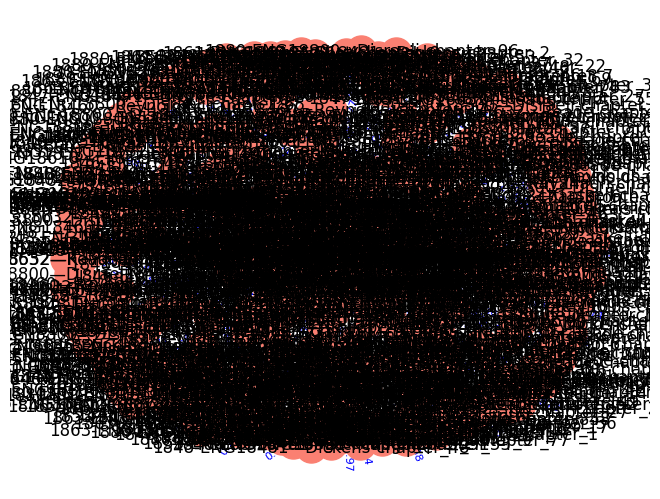

In [25]:
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G)

 # Draw nodes with labels
nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True)
# Draw edges with arrows and labels
edge_labels = nx.get_edge_attributes(G, 'comp_score')
_ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [26]:
C = CytoscapeWidget()
#C.set_layout(name='cola')
C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
C.graph.add_graph_from_networkx(G, directed=True)


In [27]:
#this is so we can programmatically edit and choose variables for the graph

def build_style(color_threshold):
    return [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'salmon',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'label': 'data(id)'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': 'black',
                 'font-family': 'helvetica',
                 'font-size': f"{TEXT_FONT_SIZE}px",
                 'color': 'blue',
                 'label': 'data(comp_score)',
                'width': f"mapData(comp_score, {min_comp_score}, {max_comp_score}, 1, 10)"
                 #'width': '10px',
             }
        },
        {
            "selector": "edge.directed",
            "style": {
                "curve-style": "bezier",
                "target-arrow-shape": "triangle",
                "target-arrow-color": "black",
            }
        }, 
        {
            "selector": f"edge[comp_score>{color_threshold}]",
            "style": {
                "line-color": "red",
            }
        },
    ]
style = build_style(0.92)
pprint(style)
C.set_style(style)

[{'selector': 'node',
  'style': {'background-color': 'salmon',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(id)'}},
 {'selector': 'edge',
  'style': {'color': 'blue',
            'font-family': 'helvetica',
            'font-size': '8px',
            'label': 'data(comp_score)',
            'line-color': 'black',
            'width': 'mapData(comp_score, 0.367, 0.989, 1, 10)'}},
 {'selector': 'edge.directed',
  'style': {'curve-style': 'bezier',
            'target-arrow-color': 'black',
            'target-arrow-shape': 'triangle'}},
 {'selector': 'edge[comp_score>0.92]', 'style': {'line-color': 'red'}}]


In [28]:
#make slider

caption = widgets.Label(value='The slider value is in its initial position.')

slider = widgets.IntSlider(
    value=90,
    min=90,
    max=100,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def handle_slider_change(change):
    color_threshold = change.new / 100
    caption.value = f"The slider value is: {color_threshold}"
    style = build_style(color_threshold=color_threshold)
    C.set_style(style)
    
slider.observe(handle_slider_change, names='value')
display(caption, slider)

Label(value='The slider value is in its initial position.')

IntSlider(value=90, continuous_update=False, description='Test:', min=90)

In [29]:
C

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'spacingFactor': 3}, cytoscape_style=[{'se…

 # MOVE OVER TO CYTOSCAPE APP FOR STRETCHY THINGS

 ## todo

 1. annotate edges in dataset
 2. regenerate all data
 3. deal with SVMs
 4. document and lock sequence alignment version
 5. fully remove and document removal of n-grams
 7. display more easy to see
 8. full dataset
 9. moving to dissertation; initial check against tarah's dataset
 10. do full relevant close re-reading
 11. 

In [30]:
p4c.cytoscape_ping()

You are connected to Cytoscape!


'You are connected to Cytoscape!'

In [31]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.10.2',
 'automationAPIVersion': '1.9.0',
 'py4cytoscapeVersion': '1.9.0'}

In [32]:
p4c.create_network_from_networkx(G)


Applying default style...
Applying preferred layout


22021